In [36]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn
!pip install imbalanced-learn  # SMOTE를 사용하기 위해 imbalanced-learn 설치

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, recall_score
from imblearn.metrics import specificity_score
from imblearn.over_sampling import BorderlineSMOTE  # SMOTE 임포트
from tslearn.preprocessing import TimeSeriesResampler
from scipy.stats import mode  # 다수결 투표를 위한 mode 함수
import random
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 랜덤 시드 고정
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [34]:
# DTW 거리 계산 함수
def compute_dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)

# Apply Borderline SMOTE to balance the dataset
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train과 X_test 사이의 DTW 거리 계산하여 대칭 행렬로 표현
dtw_matrix = np.zeros((len(X_train_resampled), len(X_test)))

# DTW 거리 계산
for i, train_series in enumerate(X_train_resampled):
    for j, test_series in enumerate(X_test):
        distance = compute_dtw_distance(train_series, test_series)
        dtw_matrix[i, j] = distance

# KNN 예측 함수 정의
def knn_predict():
    model = KNeighborsClassifier(n_neighbors=3)  # KNN 모델 정의
    model.fit(X_train_resampled, y_train_resampled)
    pred_y = model.predict(X_test)
    return pred_y

def logistic_regression_predict():
    model = LogisticRegression()
    model.fit(X_train_resampled, y_train_resampled)
    pred_y = model.predict(X_test)
    return pred_y

def cart_predict():
    model = DecisionTreeClassifier()
    model.fit(X_train_resampled, y_train_resampled)
    pred_y = model.predict(X_test)
    return pred_y

def xgboost_predict():
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train_resampled, y_train_resampled)
    pred_y = model.predict(X_test)
    return pred_y

def lstm_predict():
    # LSTM 모델을 위한 데이터 전처리
    X_train_lstm = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_lstm, y_train_resampled, epochs=50, batch_size=32, verbose=0)

    pred_y = model.predict(X_test_lstm)
    pred_y = (pred_y > 0.5).astype(int).flatten()
    return pred_y

def cnn_predict():
    # CNN 모델을 위한 데이터 전처리
    X_train_cnn = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train_resampled, epochs=50, batch_size=32, verbose=0)

    pred_y = model.predict(X_test_cnn)
    pred_y = (pred_y > 0.5).astype(int).flatten()
    return pred_y

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:49:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
KNN 모델 성능:
모델 성능 평가:
정확도: 0.7028
F1-Score: 0.7915
Recall: 0.9202
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[119 213]
 [ 42 484]]


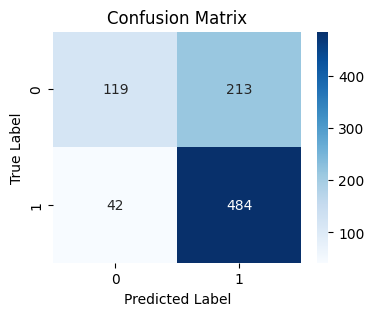

Logistic Regression 모델 성능:
모델 성능 평가:
정확도: 0.6399
F1-Score: 0.7306
Recall: 0.7966
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[130 202]
 [107 419]]


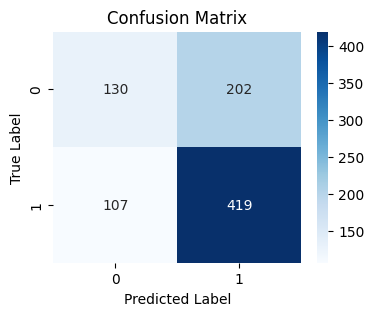

CART 모델 성능:
모델 성능 평가:
정확도: 0.6527
F1-Score: 0.7642
Recall: 0.9183
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[ 77 255]
 [ 43 483]]


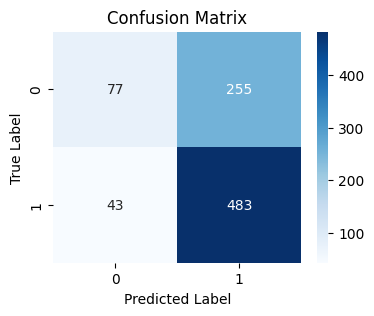

XGBoost 모델 성능:
모델 성능 평가:
정확도: 0.6807
F1-Score: 0.7876
Recall: 0.9658
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[ 76 256]
 [ 18 508]]


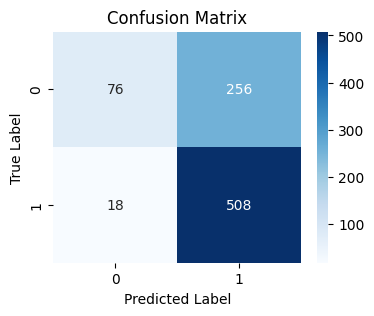

LSTM 모델 성능:
모델 성능 평가:
정확도: 0.6166
F1-Score: 0.7012
Recall: 0.7338
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[143 189]
 [140 386]]


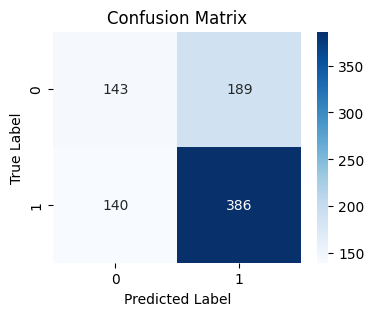

CNN 모델 성능:
모델 성능 평가:
정확도: 0.6573
F1-Score: 0.7366
Recall: 0.7814
specificity: 0.2169
혼동 행렬 (Confusion Matrix):
[[153 179]
 [115 411]]


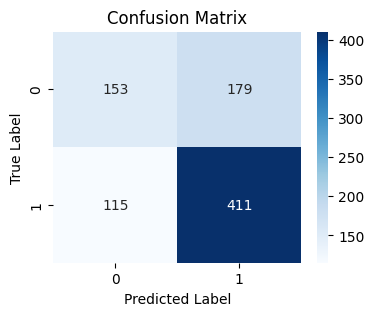

In [38]:
# 각 모델의 예측 결과를 저장할 리스트
predictions = {
    "KNN": knn_predict(),
    "Logistic Regression": logistic_regression_predict(),
    "CART": cart_predict(),
    "XGBoost": xgboost_predict(),
    "LSTM": lstm_predict(),
    "CNN": cnn_predict()
}

# 성능 평가 함수
def evaluate_model(y_test, pred_y):
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)
    return accuracy, recall, f1, conf_matrix

# 각 모델의 성능 평가
for model_name, pred_y in predictions.items():
    accuracy, recall, f1, conf_matrix = evaluate_model(y_test, pred_y)
    # 성능 지표 출력
    print(f"{model_name} 모델 성능:")
    print("모델 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()